In [10]:
# import der Bundestagsreden

import jsonlines
from sklearn.feature_extraction.text import TfidfVectorizer


# Hier legen wir fest, welche Daten (Wahlperiode 19 oder 20) wir laden:
legislatur = 20

# Wir generieren eine leere Liste:
alleReden = []

# Wir öffnen den entsprechende File (Dateipfad anpassen!):
with jsonlines.open(f'../../data/speeches_{legislatur}.jsonl') as f:
    for line in f.iter():
        # Wir packen alles Zeile für Zeile zu unserer Liste:
        alleReden.append(line)

# Wir sortieren nach Datum:
alleReden.sort(key=lambda x: x['date'])

# Wir lassen uns zeigen, wie viele Reden enthalten sind.
print(f'Die Liste enthält {len(alleReden)} Reden')
# Neue Zeile auf der Konsole:
print(f'\n')


Die Liste enthält 10791 Reden




In [76]:
# wir erstellen eine leere Menge, welche alle Parlamentarier enthalten soll, die eine Rede gehalten haben
parlamentarier = set()

# Hier werden diese Parlamentarier herausgesucht. Da es sich um ein "set" handelt, gibt es keine doppelten Einträge
for rede in alleReden:
    parlamentarier.add(rede['name'])

# Jetzt speichern wir die Reden, die diese Parlamentarier gehalten haben in einer extra Liste. Der erste Eintrag in der Liste enthält alle Reden, die der parlamentarier an erster Stelle im set gehalten hat.
aggregierte_reden_der_parlas = []
for parla in parlamentarier:
    aggregierte_reden_der_parlas.append(" ".join([rede['text'] for rede in alleReden if rede['name']==parla]))

In [77]:
# Damit die Reden semantisch verglichen werden können, müssen wir die Daten umstruktieren in eine Liste
corpus = [ aggregierte_reden_der_parlas[i] for i, parla in enumerate(parlamentarier) ]

# Dann werden tf-idf scores für jeden Parlamentarier und jedes seiner Worte berechnet
vectorizer = TfidfVectorizer(max_df=0.5, min_df=(2/781))
tf_idf_matrix  = vectorizer.fit_transform(corpus)
print(tf_idf_matrix.shape)

(753, 59376)


In [78]:
# Durch Matrixmultiplikation erhalten wir die semantische Ähnlichkeit zwischen den Reden der Parlamentariern
pairwise_similarity = tf_idf_matrix * tf_idf_matrix.T

similarity = pairwise_similarity.toarray()

In [79]:
import networkx as nx

In [80]:
G = nx.Graph()

# Da es sich bei der Variable "similarity" im erweiterten Sinne um eine Distanzmatrix handelt, können wir diese benutzen um einen Graphen zu definieren. Dabei stellt jeder Knoten einen Parlamentarier dar.
for id, parla in enumerate(parlamentarier):
    G.add_node(id, name=parla,)
print('nodes done')

# Jede Kante stellt die Ähnlichkeit der Reden der Parlamentarier dar. Es werden nur Kanten zwischen zwei Parlamentariern erstellt, wenn die Cosinus-ähnlichkeit größergleich 0.25 ist
for zeile in range(similarity.shape[0]):
    for spalte in range(similarity.shape[1]):
        if (zeile>spalte) and (similarity[zeile, spalte] >= 0.25):
            G.add_edge(zeile,spalte, weight = similarity[zeile, spalte], community=0)

print('links done')

nodes done
links done


In [83]:
# Da dadurch manche Knoten nicht mit anderen Verbunden sind, werden diese Knoten entfernt
solitary=[ n for n,d in G.degree() if d==0 ]
G.remove_nodes_from(solitary)

In [84]:
# Das reduziert die Anzahl der Knoten deutlich!
print(G)

Graph with 472 nodes and 1687 edges


In [85]:
# Jetzt können wir unseren Graphen graphisch darstellen
pos = nx.kamada_kawai_layout(G)

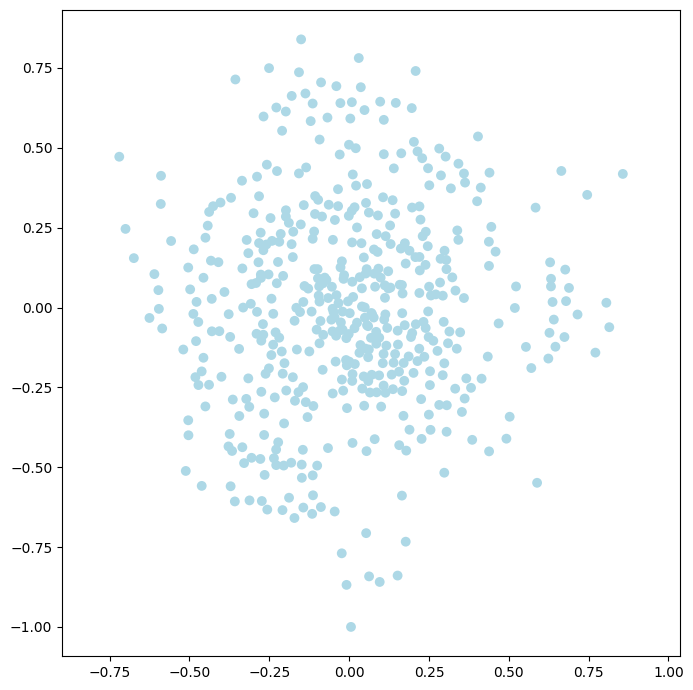

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
for p in pos.values():
    plt.scatter(p[0], p[1], c = 'lightblue', marker='o', s=50, edgecolor='None')
plt.tight_layout()
plt.axis('equal')
plt.show()